### EMG sleep/restful-awake classification from non-movement epochs

In [1]:
import os
import mne
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.signal import find_peaks
from mne.time_frequency import psd_array_multitaper

from settings import paths
from helper_functions import save_figure

In [5]:
freq_bands = {
    r'$\delta$': (1, 4),  # Delta
    r'$\theta$': (4, 8),  # Theta
    r'$\alpha$': (8, 13),  # Alpha
    r'$\beta$': (13, 30),  # Beta
    r'$\gamma$': (30, 100)  # Gamma
}

Run the below block to load the epochs of one test subject

In [4]:
epochs_dir = os.path.join(paths["epochs_folder"])

epochs = mne.read_epochs(os.path.join(epochs_dir, "filtered_epochs_w_movement_39508-epo.fif"), preload=True)

Reading C:\Users\Olle de Jong\Documents\MSc Biology\rp2\rp2_data\resting_state\output\epochs\ploss_thresh_500\filtered_epochs_w_movement_39508-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =       0.00 ...    4998.53 ms
        0 CTF compensation matrices available
Adding metadata with 5 columns
3208 matching events found
No baseline correction applied
0 projection items activated


And the below one to load all individual epoch files (all subjects)

In [3]:
epochs_dir = os.path.join(paths["epochs_folder"], "ploss_thresh_500")
epoch_objects = {}

for file in os.listdir(epochs_dir):
    if not file.startswith("filtered_epochs_w_"):
        continue
    epoch_objects.append(mne.read_epochs(os.path.join(epochs_dir, file), preload=True))

SyntaxError: unexpected character after line continuation character (2964522745.py, line 1)

### Exploratory plotting / movement and non-movement epoch comparisons

Let us create a grid plot displaying 40 random epochs per subject and annotate whether it is a movement, or non-movement epoch

In [92]:
for epochs in epoch_objects:
    movement_epoch_indexes = epochs.metadata["movement"][epochs.metadata["movement"] == True].index
    non_movement_epoch_indexes = epochs.metadata["movement"][epochs.metadata["movement"] == False].index

    random_epochs = random.sample(list(movement_epoch_indexes), 20)
    random_epochs.extend(random.sample(list(non_movement_epoch_indexes), 20))

    fig, axs = plt.subplots(5, 8, figsize=(60, 30), sharex=True, sharey=True)
    axs = axs.ravel()
    
    for plt_n, epoch_index in enumerate(random_epochs):
        sns.lineplot(epochs[epoch_index].get_data("EMG_L").flatten(), label="EMG_L", legend=True, ax=axs[plt_n])
        sns.lineplot(epochs[epoch_index].get_data("EMG_R").flatten(), label="EMG_R", legend=True, ax=axs[plt_n])
        axs[plt_n].set_title(f"Epoch {epoch_index}. Movement: {epochs.metadata['movement'][epoch_index]}")
        plt.plot(np.zeros_like(epochs[epoch_index].get_data("EMG_L").flatten()), "--", color="black")
        
    plt.subplots_adjust(wspace=0.08, hspace=0.08)
    plt.suptitle(f"{epochs.metadata['animal_id'][0]}")
    save_figure(os.path.join(paths["plots_folder"], "ploss_thresh_500", f"emg_test/{epochs.metadata['animal_id'][0]}"))

These figures show us that there are feature differences between the non-movement and movement epochs. Based on these figures, we will now create a dictionary holding information on the data quality of the two EMG channels for each subject. Each item of the dict holds either the names of two, or one 'good quality' EMG channel.

In [6]:
quality_emgs = {
    81217: ["EMG_L"],
    81175: ["EMG_L", "EMG_R"],
    79592: ["EMG_R"],
    79593: ["EMG_L"],
    81207: ["EMG_R"],
    80625: ["EMG_R"],
    80630: ["EMG_L", "EMG_R"],
    78211: ["EMG_R"],
    39489: ["EMG_L"],
    80620: ["EMG_L", "EMG_R"],
    78227: ["EMG_L", "EMG_R"],
    78233: ["EMG_R"],
    39508: ["EMG_L", "EMG_R"],
    79604: ["EMG_L", "EMG_R"],
    81218: ["EMG_L", "EMG_R"],
    79602: ["EMG_L"],
    78244: ["EMG_L", "EMG_R"],
    81193: ["EMG_L", "EMG_R"],
}

Let's try to obtain some features that we might be able to train a ML algorithm on.

#### Average log transformed, normalized PSD gamma band

39508 ['EMG_L', 'EMG_R']


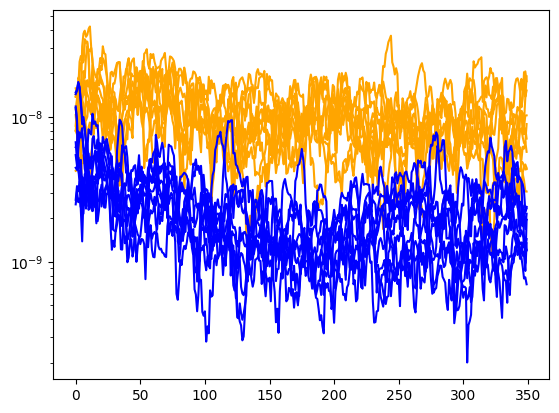

In [213]:
for epochs in [epoch_objects[10]]:
    # get subject id, and the names of the quality EMG channels
    subject_id = epochs.metadata['animal_id'][0]
    quality_emg_chans = quality_emgs[int(subject_id)]
    print(subject_id, quality_emg_chans)
    
    movement_epoch_indexes = epochs.metadata["movement"][epochs.metadata["movement"] == True].index
    non_movement_epoch_indexes = epochs.metadata["movement"][epochs.metadata["movement"] == False].index

    random_epochs = random.sample(list(movement_epoch_indexes), 5)
    random_epochs.extend(random.sample(list(non_movement_epoch_indexes), 5))
    
    psd_means_non_mov, psd_means_mov = [], []
    psd_means_non_mov_r, psd_means_mov_r = [], []
    for plt_n, epoch_index in enumerate(random_epochs):
        behaviour = epochs[epoch_index].metadata["movement"].iloc[0]
        
        psd, freq = psd_array_multitaper(epochs[epoch_index].get_data(picks=quality_emg_chans), fmin=30, fmax=100,sfreq=epochs.info['sfreq'], n_jobs=-1)
        
        for i, emg_chan in enumerate(quality_emg_chans):
            sns.lineplot(psd[0,i,:], color="orange" if behaviour == True else "blue")
            
            # add mean of log transformed PSD for this epoch to the right container
            if behaviour:  # movement
                if emg_chan == "EMG_L":
                    psd_means_mov.append(np.mean(np.log(psd[0,i,:])))
                else:
                    psd_means_mov_r.append(np.mean(np.log(psd[0,i,:])))
            else:  # non-movement
                if emg_chan == "EMG_L":
                    psd_means_non_mov.append(np.mean(np.log(psd[0,i,:])))
                else:
                    psd_means_non_mov_r.append(np.mean(np.log(psd[0,i,:])))

    plt.yscale('log')
    plt.show()
    break

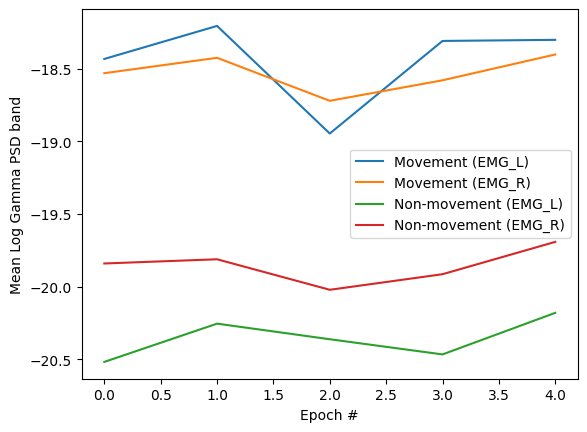

In [214]:
plt.plot(psd_means_mov, label="Movement (EMG_L)")
plt.plot(psd_means_mov_r, label="Movement (EMG_R)")
plt.plot(psd_means_non_mov, label="Non-movement (EMG_L)")
plt.plot(psd_means_non_mov_r, label="Non-movement (EMG_R)")
plt.xlabel("Epoch #")
plt.ylabel("Mean Log Gamma PSD band")
plt.legend()

### Average log transformed, normalized PSD calculations for all frequency bands
Now, let's calculate the mean log transformed PSD for all bands. These will later be used to perform clustering.

In [26]:
df = pd.DataFrame(columns=["subject_id", "epoch_n", "emg_chan", "movement", "mean_psd_delta", "mean_psd_theta", "mean_psd_alpha", "mean_psd_beta", "mean_psd_gamma"])

for epochs in epoch_objects:
    subject_id = epochs.metadata['animal_id'][0]
    quality_emg_chans = quality_emgs[int(subject_id)]
    
    for i, epoch in enumerate(epochs):
        behaviour = epochs[i].metadata["movement"].iloc[0]
        
        psds = {}
        for band, (start, end) in freq_bands.items():
            psd, freq = psd_array_multitaper(epochs[i].get_data(picks=quality_emg_chans), fmin=start, fmax=end,sfreq=epochs.info['sfreq'], n_jobs=-1)
            if psd.shape[1] > 1:
                psds[band] = {"EMG_L": np.mean(np.log(psd[0,0,:])), "EMG_R": np.mean(np.log(psd[0,1,:]))}
            else:
                psds[band] = {quality_emg_chans[0]: np.mean(np.log(psd[0,0,:]))}
        
        keys = list(psds.keys())
        if len(quality_emg_chans) != 2:
            emg_chan = quality_emg_chans[0]
            df.loc[len(df)+1] = [subject_id, i, emg_chan, behaviour, psds[keys[0]][emg_chan], psds[keys[1]][emg_chan], psds[keys[2]][emg_chan], psds[keys[3]][emg_chan], psds[keys[4]][emg_chan]]
        else:
            for emg_chan in quality_emg_chans: 
                df.loc[len(df)+1] = [subject_id, i, emg_chan, behaviour, psds[keys[0]][emg_chan], psds[keys[1]][emg_chan], psds[keys[2]][emg_chan], psds[keys[3]][emg_chan], psds[keys[4]][emg_chan]]
    print(subject_id, ", done.")

39508 , done.


/var/folders/rf/xrxwkkr96qq6kyy5jfx9hvgw0000gn/T/ipykernel_775/3038424094.py:24: RuntimeWarning: divide by zero encountered in log
  psds[band] = {"EMG_L": np.mean(np.log(psd[0,0,:])), "EMG_R": np.mean(np.log(psd[0,1,:]))}


At least the mean of the Gamma band seems to be a good measure when aiming to separate the non-sleep and sleep epochs in the non-movement epochs. Adding the other values as features for a clustering algorithm will probably not increase its accuracy, as the mean of the log transformed PSD of the bands are very comparable when the EMG epoch signal is of 'high' quality.

### Clustering

In [68]:
df.head()

,subject_id,epoch_n,emg_chan,movement,mean_psd_delta,mean_psd_theta,mean_psd_alpha,mean_psd_beta,mean_psd_gamma
1,39508,0,EMG_L,1,-14.834079,-16.136019,-16.418628,-17.653490,-18.311828
2,39508,0,EMG_R,1,-14.984551,-16.523346,-16.540829,-17.798912,-18.425358
3,39508,1,EMG_L,1,-15.421758,-16.781017,-16.574465,-17.576754,-17.890491
4,39508,1,EMG_R,1,-14.826422,-16.116654,-16.821486,-18.045887,-18.620344
5,39508,2,EMG_L,1,-14.605641,-15.693569,-16.017228,-18.060907,-17.583236


Let's transform the movement column from type str to numeric.

In [58]:
df["movement"] = df["movement"].astype(int)
df.head()

,subject_id,epoch_n,emg_chan,movement,mean_psd_delta,mean_psd_theta,mean_psd_alpha,mean_psd_beta,mean_psd_gamma
1,39508,0,EMG_L,1,-14.834079,-16.136019,-16.418628,-17.653490,-18.311828
2,39508,0,EMG_R,1,-14.984551,-16.523346,-16.540829,-17.798912,-18.425358
3,39508,1,EMG_L,1,-15.421758,-16.781017,-16.574465,-17.576754,-17.890491
4,39508,1,EMG_R,1,-14.826422,-16.116654,-16.821486,-18.045887,-18.620344
5,39508,2,EMG_L,1,-14.605641,-15.693569,-16.017228,-18.060907,-17.583236


Now, let's remove the Inf values, and slice the numerical data out of the original df, and scale the features using the StandardScaler.

In [61]:
# remove possible Inf values and grab numerical columns
df = df.replace([np.inf, -np.inf], np.nan).dropna()
df_numeric = df.iloc[:, 3:]

# scale
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_numeric)
df_numeric.head()

,movement,mean_psd_delta,mean_psd_theta,mean_psd_alpha,mean_psd_beta,mean_psd_gamma
1,1,-14.834079,-16.136019,-16.418628,-17.653490,-18.311828
2,1,-14.984551,-16.523346,-16.540829,-17.798912,-18.425358
3,1,-15.421758,-16.781017,-16.574465,-17.576754,-17.890491
4,1,-14.826422,-16.116654,-16.821486,-18.045887,-18.620344
5,1,-14.605641,-15.693569,-16.017228,-18.060907,-17.583236


#### Actual clustering

For now, we will cluster into two groups on all numerical data. So, this includes the column on whether it is a movement, or non-movement epoch. In theory, this would result in near perfect separation.

In [63]:
kmeans = KMeans(random_state=40, n_clusters=2)
kmeans.fit(scaled_features)
np.unique(kmeans.labels_, return_counts=True)[1]

array([5613,  801])

So, there are 5613 epochs in cluster 0, and 801 in cluster 1. Let's see how many movement and non-movement epochs there are.

In [67]:
print(f"Movement: {len(df_numeric[df_numeric.movement == 1])}, non-movement: {len(df_numeric[df_numeric.movement == 0])}")

Movement: 5636, non-movement: 778


The amount of epochs in cluster 0 and the actual movement epochs, and the number of epochs in cluster 1 and the actual amount of non-movement epochs are very close.

[[ 0.30961589 -0.66734667]
 [ 0.93722983 -0.80437148]
 [ 0.86133065 -1.66775078]
 ...
 [ 0.31883147  0.30659263]
 [18.64842     2.01157376]
 [12.58796353  2.31983422]]


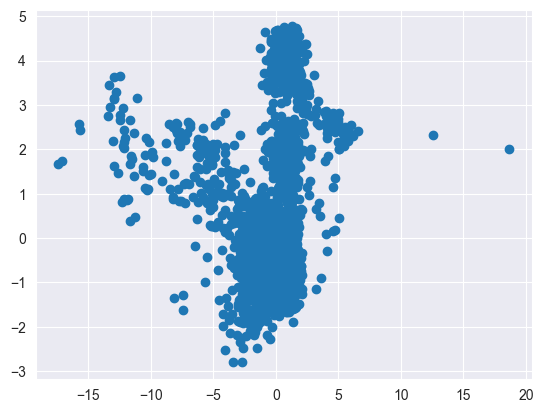

In [76]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_features)
plt.scatter(principal_components[:, 0], principal_components[:, 1])


#### Losing the movement column

Now, let's see if we leave out information.

In [77]:
df_numeric = df.iloc[:, 4:]
# scale
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_numeric)

In [78]:
kmeans = KMeans(random_state=40, n_clusters=2)
kmeans.fit(scaled_features)
np.unique(kmeans.labels_, return_counts=True)[1]

array([6244,  170])

It seems like losing the movement column makes the clustering less accurate for separating movement from non-movement epochs, which makes a lot of sense.

#### Clustering the non-movement epochs

In [132]:
df_non_mov = df[df.movement == False]
features_df = df_non_mov.iloc[:, 4:]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_df)

In [133]:
kmeans = KMeans(random_state=40, n_clusters=2)
kmeans.fit(scaled_features)
np.unique(kmeans.labels_, return_counts=True)[1]

array([416, 362])

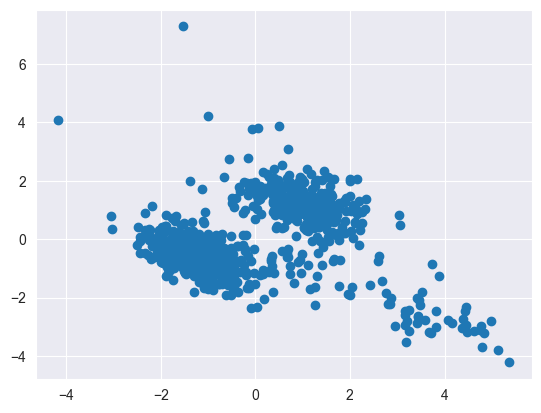

In [134]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_features)
plt.scatter(principal_components[:, 0], principal_components[:, 1])

Now, let's plot this along with the clusters.

First, we add the principle component data to our numerical dataframe

In [135]:
# concat the original data and the components
df_plot = pd.concat([df_non_mov.reset_index(drop=True), pd.DataFrame(principal_components)], axis=1)
df_plot.head()

,subject_id,epoch_n,emg_chan,movement,mean_psd_delta,mean_psd_theta,mean_psd_alpha,mean_psd_beta,mean_psd_gamma,0,1
0,39508,71,EMG_L,0,-15.122361,-16.251809,-16.274883,-17.341573,-18.204397,1.417642,2.027527
1,39508,71,EMG_R,0,-15.229335,-16.532472,-16.095687,-17.769207,-18.400488,1.748622,1.031983
2,39508,72,EMG_L,0,-14.744674,-15.736566,-16.936179,-17.808171,-18.146900,1.478712,1.275135
3,39508,72,EMG_R,0,-14.620380,-15.790112,-16.971779,-17.945769,-18.587934,1.381664,0.643585
4,39508,73,EMG_L,0,-15.390192,-14.724281,-17.286025,-18.307349,-19.005761,1.296192,0.080804


And then we add the cluster label

In [136]:
df_plot["K-means Cluster"] = kmeans.labels_
df_plot.head()

,subject_id,epoch_n,emg_chan,movement,mean_psd_delta,mean_psd_theta,mean_psd_alpha,mean_psd_beta,mean_psd_gamma,0,1,K-means Cluster
0,39508,71,EMG_L,0,-15.122361,-16.251809,-16.274883,-17.341573,-18.204397,1.417642,2.027527,1
1,39508,71,EMG_R,0,-15.229335,-16.532472,-16.095687,-17.769207,-18.400488,1.748622,1.031983,1
2,39508,72,EMG_L,0,-14.744674,-15.736566,-16.936179,-17.808171,-18.146900,1.478712,1.275135,1
3,39508,72,EMG_R,0,-14.620380,-15.790112,-16.971779,-17.945769,-18.587934,1.381664,0.643585,1
4,39508,73,EMG_L,0,-15.390192,-14.724281,-17.286025,-18.307349,-19.005761,1.296192,0.080804,1


Now, we plot.

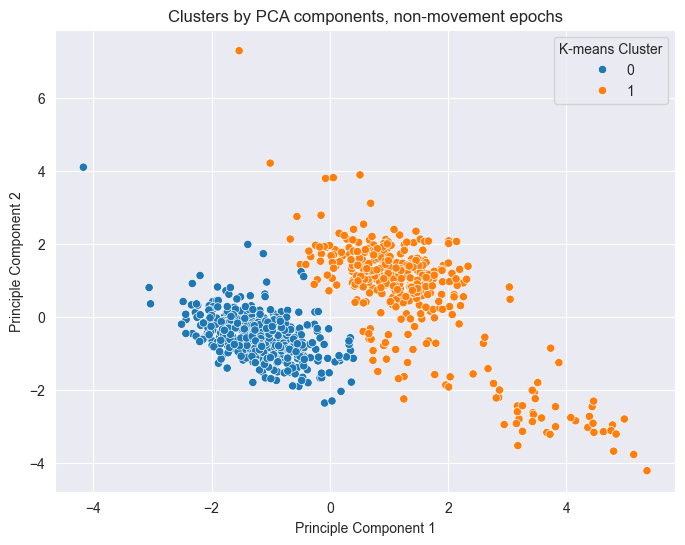

In [137]:
fig = plt.figure(figsize=(8,6))
sns.scatterplot(data=df_plot, x=0, y=1, hue="K-means Cluster")
plt.title("Clusters by PCA components, non-movement epochs")
plt.xlabel("Principle Component 1")
plt.ylabel("Principle Component 2")
plt.show()

Clearly there are two clusters here. Probably cluster 1 are the epochs that have more gamma frequency as they have more outlierish datapoints. Cluster 0 does not have that many epochs with outliers/artifacts and are likely epochs with low frequency waves, causing fewer artifacts in the EMG readouts.

Now, let's plot the mean signal of each cluster

In [147]:
df_plot.head()

,subject_id,epoch_n,emg_chan,movement,mean_psd_delta,mean_psd_theta,mean_psd_alpha,mean_psd_beta,mean_psd_gamma,0,1,K-means Cluster
0,39508,71,EMG_L,0,-15.122361,-16.251809,-16.274883,-17.341573,-18.204397,1.417642,2.027527,1
1,39508,71,EMG_R,0,-15.229335,-16.532472,-16.095687,-17.769207,-18.400488,1.748622,1.031983,1
2,39508,72,EMG_L,0,-14.744674,-15.736566,-16.936179,-17.808171,-18.146900,1.478712,1.275135,1
3,39508,72,EMG_R,0,-14.620380,-15.790112,-16.971779,-17.945769,-18.587934,1.381664,0.643585,1
4,39508,73,EMG_L,0,-15.390192,-14.724281,-17.286025,-18.307349,-19.005761,1.296192,0.080804,1


From this dataframe, we know what cluster each non-movement epoch is in, so why don't we go ahead and plot the EMG_L and EMG_R average signal per cluster. That way we can be certain what kind of epochs are in the different clusters.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


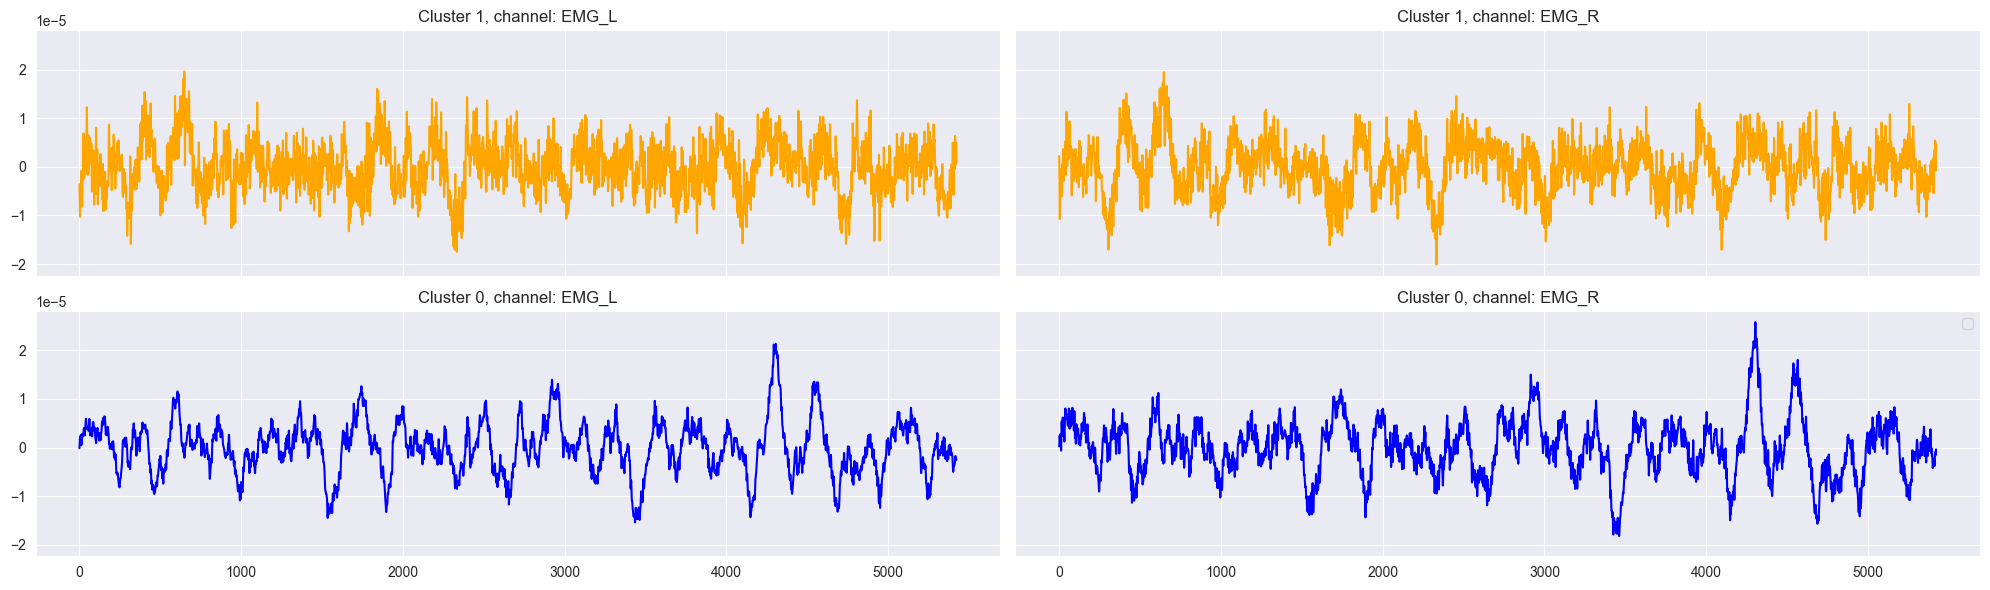

In [172]:
unique_clusters = df_plot["K-means Cluster"].unique()
unique_emg_chans = df_plot["emg_chan"].unique()

fig, axes = plt.subplots(nrows=len(unique_emg_chans), ncols=len(unique_clusters), figsize=(20, 3 * len(unique_emg_chans)), sharex=True, sharey=True)
axes = axes.ravel()

i = 0
for cluster in unique_clusters:
    # get the cluster data from the dataframe
    cluster_data = df_plot[df_plot["K-means Cluster"] == cluster]
    
    for emg_chan in unique_emg_chans:
        cluster_data_chan = cluster_data[cluster_data["emg_chan"] == emg_chan]

        # get epoch indexes
        epoch_indexes = cluster_data_chan["epoch_n"].unique()
        # get correct epoch data
        epoch_data = epoch_objects[0][epoch_indexes].get_data(picks=emg_chan)
        # average the epochs of this channel and cluster
        mean = np.mean(epoch_data, axis=0)[0]
        
        axes[i].plot(mean, color="orange" if cluster == 1 else "blue")
        axes[i].set_title(f"Cluster {cluster}, channel: {emg_chan}")
        i += 1

plt.legend()
plt.tight_layout()
plt.show()

As can be seen in the plot above, the clustering neatly separates the two by eye separable types of epochs. One has high frequency waves (Gamma), the other does not. This plot furthermore confirms that cluster 0, which can be seen in the PCA plot above, likely holds sleep epochs. Or at least epochs with limited amount of gamma waves, which are associated with high-level cognitive functions, such as memory recall, perception, and conscious awareness.

### Sleep / rest epoch separation

First, we need to merge the original data dataframe with the non-movement clustering dataframe in order to get all data together. Only then we can visualize the non-movment clusters on the entire data.

In [228]:
merged_df = pd.merge(df, df_plot, how="left")
merged_df.drop(columns=[0, 1], inplace=True)
merged_df.iloc[140:145]

,subject_id,epoch_n,emg_chan,movement,mean_psd_delta,mean_psd_theta,mean_psd_alpha,mean_psd_beta,mean_psd_gamma,K-means Cluster
140,39508,70,EMG_L,1,-14.965127,-15.236255,-17.113737,-18.186705,-18.834583,NaN
141,39508,70,EMG_R,1,-14.868636,-15.230328,-16.932604,-18.287569,-18.847610,NaN
142,39508,71,EMG_L,0,-15.122361,-16.251809,-16.274883,-17.341573,-18.204397,1.0
143,39508,71,EMG_R,0,-15.229335,-16.532472,-16.095687,-17.769207,-18.400488,1.0
144,39508,72,EMG_L,0,-14.744674,-15.736566,-16.936179,-17.808171,-18.146900,1.0


We have to perform PCA on the entire dataframe holding the same columns, so let's do that.

In [229]:
df_numeric = df.iloc[:, 4:]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_numeric)

In [230]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_features)
merged_df = pd.concat([merged_df.reset_index(drop=True), pd.DataFrame(principal_components)], axis=1)
merged_df.iloc[140:145]

,subject_id,epoch_n,emg_chan,movement,mean_psd_delta,mean_psd_theta,mean_psd_alpha,mean_psd_beta,mean_psd_gamma,K-means Cluster,0,1
140,39508,70,EMG_L,1,-14.965127,-15.236255,-17.113737,-18.186705,-18.834583,NaN,1.191775,0.858410
141,39508,70,EMG_R,1,-14.868636,-15.230328,-16.932604,-18.287569,-18.847610,NaN,1.087164,0.983516
142,39508,71,EMG_L,0,-15.122361,-16.251809,-16.274883,-17.341573,-18.204397,1.0,0.143059,-1.062133
143,39508,71,EMG_R,0,-15.229335,-16.532472,-16.095687,-17.769207,-18.400488,1.0,0.742974,-0.807971
144,39508,72,EMG_L,0,-14.744674,-15.736566,-16.936179,-17.808171,-18.146900,1.0,0.583544,-0.347094


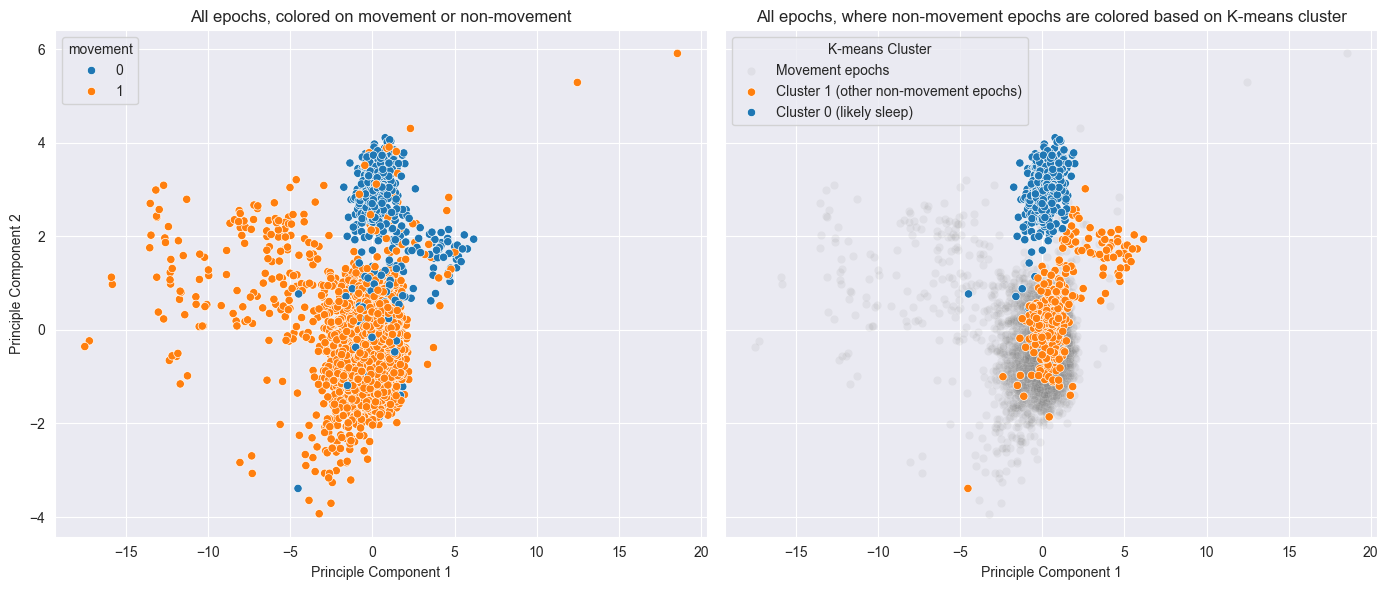

In [256]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, sharex=True, figsize=(14, 6))
sns.scatterplot(data=merged_df, x=0, y=1, hue="movement", ax=ax1)
sns.scatterplot(data=merged_df[merged_df['K-means Cluster'].isna()], x=0, y=1, color='grey', alpha=0.1, ax=ax2)  # plot NaNs explicitly
sns.scatterplot(data=merged_df, x=0, y=1, hue="K-means Cluster", ax=ax2)

ax1.set_title("All epochs, colored on movement or non-movement")
ax2.set_title("All epochs, where non-movement epochs are colored based on K-means cluster")
ax1.set_xlabel("Principle Component 1")
ax2.set_xlabel("Principle Component 1")
ax1.set_ylabel("Principle Component 2")
legend_labels = ['Movement epochs', 'Cluster 1 (other non-movement epochs)', 'Cluster 0 (likely sleep)']
ax2.legend(title='K-means Cluster', labels=legend_labels)
plt.tight_layout()
plt.show()

In [ ]:
# TODO:
#  - Try out other features
#  - Create a neater features dataframe that holds a row per EMG channel
#  - It should have the epoch number and start- and endframes of the epoch
#  - Everytime you add features, you need to perform principle component analysis again and plot all epochs, then color them based on the non-movement clustering on the same features



























### Peak-to-peak

In [38]:
df.head()

,subject_id,epoch_n,emg_chan,movement,mean_psd_delta,mean_psd_theta,mean_psd_alpha,mean_psd_beta,mean_psd_gamma
1,39508,0,EMG_L,True,-14.834079,-16.136019,-16.418628,-17.653490,-18.311828
2,39508,0,EMG_R,True,-14.984551,-16.523346,-16.540829,-17.798912,-18.425358
3,39508,1,EMG_L,True,-15.421758,-16.781017,-16.574465,-17.576754,-17.890491
4,39508,1,EMG_R,True,-14.826422,-16.116654,-16.821486,-18.045887,-18.620344
5,39508,2,EMG_L,True,-14.605641,-15.693569,-16.017228,-18.060907,-17.583236


In [54]:
rand_epoch = random.sample(range(len(epoch_objects[0])), 1)
print("Random epoch index:", rand_epoch)
emg_r = epoch_objects[0][rand_epoch].get_data("EMG_R").flatten()
peaks, _ = find_peaks(emg_r, height=.00015)
print(len(peaks), df[df.epoch_n == rand_epoch[0]].movement.iloc[0])

Random epoch index: [3016]
14 False


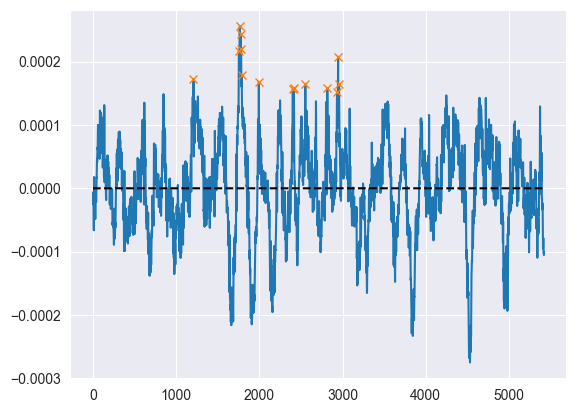

In [55]:
plt.plot(emg_r)
plt.plot(peaks, emg_r[peaks], "x")
plt.plot(np.zeros_like(emg_r), "--", color="black")

Random epoch index: [1181]
44 1


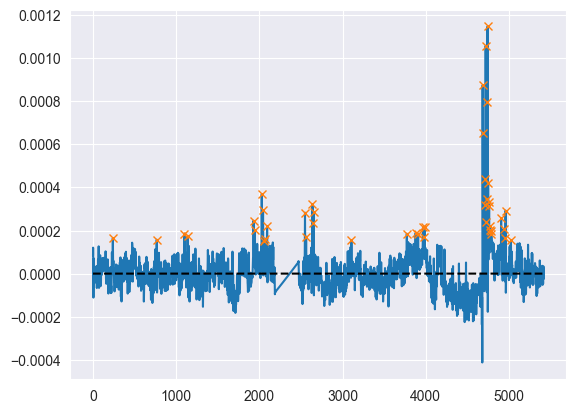

In [275]:
rand_epoch = random.sample(range(len(epoch_objects[0])), 1)
print("Random epoch index:", rand_epoch)
emg_r = epoch_objects[0][6].get_data("EMG_R").flatten()
peaks, _ = find_peaks(emg_r, height=.00015)
print(len(peaks), df[df.epoch_n == rand_epoch[0]].movement.iloc[0])
plt.plot(emg_r)
plt.plot(peaks, emg_r[peaks], "x")
plt.plot(np.zeros_like(emg_r), "--", color="black")